
# Teste A/B
## Páginas com Avaliações de Usuários Aumentam as Vendas de Produtos Online?

## Como Analisar Testes A/B?

Em geral, realizamos esses 5 passos para analisar um Teste A/B:

1. Configuramos o experimento.

2. Executamos o teste de hipóteses e registramos a taxa de sucesso de cada grupo.

3. Criamos o Plot da distribuição da diferença entre as duas amostras.

4. Calculamos o poder estatístico.

5. Avaliamos como o tamanho das amostras afeta os Testes A/B.


## Carregando o Conjunto de Dados

In [1]:
# Imports
import datetime
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs

## Carregando e Compreendendo os Dados

Variante A: Mostra o número atual de comentários e avaliações de usuários.

Variante B: Não mostra os comentários de usuários no site.

In [2]:
# Carrega o dataset
# Usaremos dados fictícios, que representam valores que seriam possíves em um teste real
df_vendas = pd.read_csv("dados/dataset.csv")

In [3]:
# Visualiza 
df_vendas.head()

,id,variante,compra,data
0,0x6f9421,A,False,2019-12-26
1,0x59d442,A,False,2019-08-16
2,0x6db8f8,A,True,2019-03-18
3,0x68245d,A,False,2019-02-13
4,0x28566e,A,False,2019-09-28


In [4]:
# Visualiza 
df_vendas.tail()

,id,variante,compra,data
54995,0x451451,A,False,2019-06-19
54996,0x871d51,A,False,2019-03-22
54997,0x50d163,A,False,2019-02-10
54998,0x3544c4,B,False,2020-01-09
54999,0x983331,A,False,2019-09-05


## Análise Exploratória e Cálculo de Probabilidade

In [5]:
# Shape dos dados
df_vendas.shape

(55000, 4)

In [6]:
# Tipos de dados
df_vendas.dtypes

id          object
variante    object
compra        bool
data        object
dtype: object

In [7]:
# Data máxima
df_vendas['data'].max()

'2020-01-30'

In [8]:
# Data mínima
df_vendas['data'].min()

'2019-01-01'

In [9]:
# Checamos por valores nulos
df_vendas.isnull().sum()

id          0
variante    0
compra      0
data        0
dtype: int64

In [10]:
# Checamos se temos IDs duplicados
df_vendas.id.value_counts().count()

55000

In [11]:
# Proporção do resultado de conversão
df_vendas.compra.value_counts()

False    46416
True      8584
Name: compra, dtype: int64

In [12]:
# Proporção das variantes mostradas aos usuários
df_vendas.variante.value_counts()

A    50000
B     5000
Name: variante, dtype: int64

Calculando probabilidades básicas.

**Variante A é o grupo de controle. Variante B é o grupo de teste ou tratamento.**

In [13]:
# Probabilidade de um usuário visualizar a variante A
df_vendas[df_vendas.variante == 'A'].shape[0] / df_vendas.shape[0] * 100

90.9090909090909

In [14]:
# Probabilidade de um usuário visualizar qualquer variante
df_vendas.shape[0] / df_vendas.shape[0] * 100

100.0

In [15]:
# Probabilidade de um usuário visualizar a variante B
df_vendas[df_vendas.variante == 'B'].shape[0] / df_vendas.shape[0] * 100

9.090909090909092

In [16]:
# Total de compras realizadas (conversões)
df_vendas.compra.sum()

8584

In [17]:
# Total de compras realizadas quando a variante era A
df_vendas[df_vendas.variante == 'A'].compra.sum()

7603

In [18]:
# Total de compras realizadas quando a variante era B
df_vendas[df_vendas.variante == 'B'].compra.sum()

981

In [19]:
# Probabilidade de conversão independente da variante recebida
df_vendas.compra.mean()

0.15607272727272728

In [20]:
# Dado que um indivíduo estava no grupo de controle, qual é a probabilidade de conversão?
df_vendas[df_vendas.variante == 'A'].compra.mean()

0.15206

In [21]:
# Dado que um indivíduo estava no grupo de tratamento, qual é a probabilidade de conversão?
df_vendas[df_vendas.variante == 'B'].compra.mean()

0.1962

Como vemos, a probabilidade de receber a nova página é de aproximadamente 10% e a probabilidade total de conversão é de 19%. Precisamos checar se temos evidências suficientes para dizer que o grupo de tratamento leva a um aumento das conversões.

## Tarefa 1 - Configurando o Experimento

Páginas com Avaliações de Usuários Aumentam as Vendas de Produtos Online?

Variante A: Mostra o número atual de comentários e avaliações de usuários

Variante B: Não mostra os comentários de usuários no site


- H0: PB - PA = 0
- H1: PB - PA > 0

H0 nos diz que a diferença de probabilidade dos dois grupos é igual a zero.

H1 nos diz que a diferença de probabilidade dos dois grupos é maior do que zero.

### Pré-Processamento dos Dados


In [22]:
# Função para extrair ano e mês da data
def extrai_data(x):
    return x[:7]

In [23]:
# Extrai ano e mês da coluna de data
df_vendas['ano_mes'] = df_vendas['data'].apply(extrai_data)

In [24]:
# Visualiza
df_vendas.head()

,id,variante,compra,data,ano_mes
0,0x6f9421,A,False,2019-12-26,2019-12
1,0x59d442,A,False,2019-08-16,2019-08
2,0x6db8f8,A,True,2019-03-18,2019-03
3,0x68245d,A,False,2019-02-13,2019-02
4,0x28566e,A,False,2019-09-28,2019-09


In [25]:
# Vamos trabalhar apenas com os dados de Janeiro/2020 para simplificar o processo didaticamente
df_vendas_2020 = df_vendas[df_vendas['ano_mes'] == '2020-01']

In [26]:
# Visualiza
df_vendas_2020.head()

,id,variante,compra,data,ano_mes
5,0x792f1d,A,False,2020-01-14,2020-01
7,0x724b78,B,False,2020-01-23,2020-01
9,0x684bf9,A,False,2020-01-17,2020-01
10,0x6394dc,A,False,2020-01-06,2020-01
11,0x625f5d,A,False,2020-01-05,2020-01


In [27]:
# shape
df_vendas_2020.shape

(8821, 5)

### Criação do Baseline

Vamos criar um baseline (linha base) da taxa de conversão antes de executar o teste de hipótese. Assim, saberemos a taxa de conversão base e o aumento desejado em compras que gostaríamos de testar.

* A será o grupo de controle 
* B será o grupo de teste

In [28]:
# Geramos um dataframe
df_ab_data = df_vendas_2020[['variante', 'compra']]
df_ab_data.head()

,variante,compra
5,A,False
7,B,False
9,A,False
10,A,False
11,A,False


In [29]:
# Shape
df_ab_data.shape

(8821, 2)

In [30]:
# Altera o nome das colunas
df_ab_data.columns = ['grupo', 'conversao']

In [31]:
# Visualiza
df_ab_data.head()

,grupo,conversao
5,A,False
7,B,False
9,A,False
10,A,False
11,A,False


In [32]:
# Tabela pivot para o sumário dos dados
df_ab_sumario = df_ab_data.pivot_table(values = 'conversao', index = 'grupo', aggfunc = np.sum)

In [33]:
# Visualiza os dados
df_ab_sumario.head()

,conversao
grupo,
A,587
B,981


In [34]:
# Sumário com total 
df_ab_sumario['total'] = df_ab_data.pivot_table(values = 'conversao', index = 'grupo', aggfunc = lambda x: len(x))

In [35]:
# Sumário com taxa
df_ab_sumario['taxa'] = df_ab_data.pivot_table(values = 'conversao', index = 'grupo')

In [36]:
# Visualiza os dados
df_ab_sumario.head()

,conversao,total,taxa
grupo,,,
A,587,3821,0.153625
B,981,5000,0.196200


In [37]:
# Obtemos os valores da variante A
conversao_A = df_ab_sumario['conversao'][0]
total_A = df_ab_sumario['total'][0]
taxa_A = df_ab_sumario['taxa'][0]

In [38]:
# Imprime os valores de A
print(conversao_A)
print(total_A)
print(taxa_A)

587
3821
0.15362470557445695


In [39]:
# Obtemos os valores da variante B
conversao_B = df_ab_sumario['conversao'][1]
total_B = df_ab_sumario['total'][1]
taxa_B = df_ab_sumario['taxa'][1]

In [40]:
# Imprime os valores de B
print(conversao_B)
print(total_B)
print(taxa_B)

981
5000
0.1962


Taxa de conversão da linha de base (Baseline conversion rate).

Igual a $p$ no contexto de uma distribuição binomial e $p$ é a probabilidade de sucesso.

In [41]:
# Taxa de conversão da linha de base.
conversao_base = taxa_A
conversao_base

0.15362470557445695

Efeito mínimo detectável (Minimum Detectable Effect).


In [42]:
# Efeito mínimo detectável
efeito_minimo = taxa_B - taxa_A
efeito_minimo

0.04257529442554306

## Tarefa 2 - Execução do Teste de Hipóteses

Executamos o teste de hipóteses e registramos a taxa de sucesso de cada grupo.

In [43]:
# Parâmetros que usaremos para executar o teste
alfa = 0.05
beta = 0.2

In [44]:
# Tamanho da amostra
n = 50000

Podemos supor que a distribuição de nosso grupo de controle é binomial porque os dados são uma série de tentativas de Bernoulli, em que cada tentativa tem apenas dois resultados possíveis (semelhante a um cara ou coroa).
 
 Para o teste usaremos a função binom() do SciPy:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html

In [45]:
# Teste Binomial (usando padrão de 5% para o nível de significância)
teste_binom = scs.binom(n, p = conversao_base)

In [46]:
# Teste Binomial com o efeito mínimo (no nosso exemplo 0.04 para o nível de significância)
teste_binom_mde = scs.binom(n, p = conversao_base + efeito_minimo)

Agora visualizamos a probability mass function (pmf).

C:\Users\Gustavo_Gorki\anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


<BarContainer object of 50001 artists>

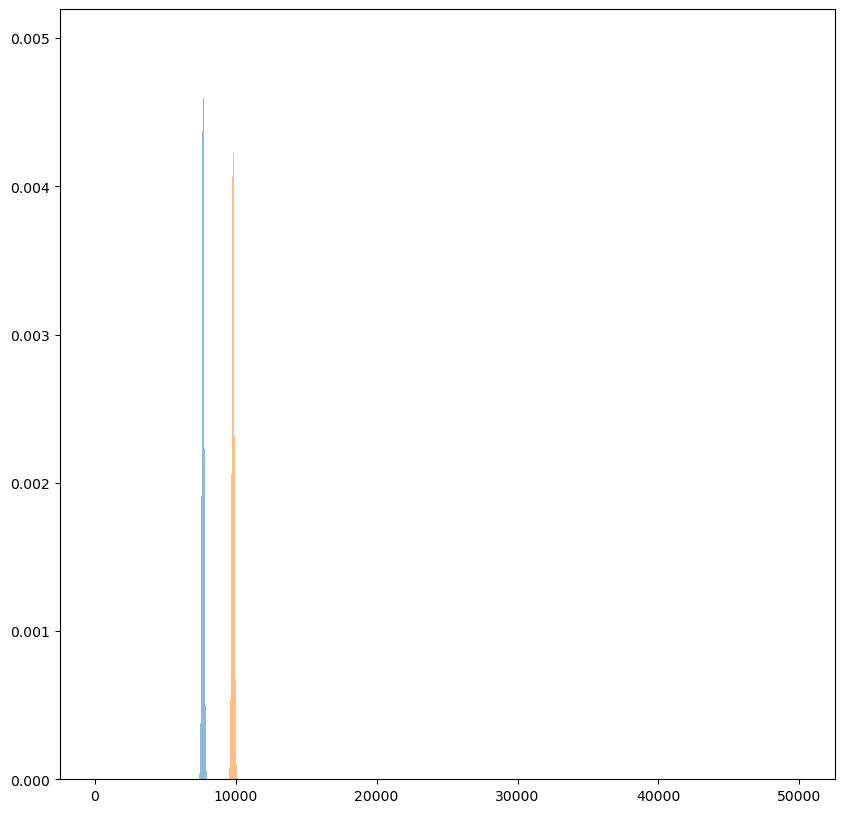

In [47]:
# Plot

# Área de plotagem
fig, ax = plt.subplots(figsize = (10, 10))

# Definimos diversos valores para x
x = np.linspace(0,int(n), int(n) + 1)

# Plotamos os resultados com a pmf e alfa de 0.5
ax.bar(x, teste_binom.pmf(x), alpha = 0.5)
ax.bar(x, teste_binom_mde.pmf(x), alpha = 0.5)

## Tarefa 3 - Plot da Distribuição

Criamos o Plot da distribuição da diferença entre as duas amostras e comparamos os resultados.

Podemos comparar os dois grupos traçando a distribuição do grupo de controle e calculando a probabilidade de obter o resultado de nosso grupo de teste.

Text(0, 0.5, 'Probabilidade')

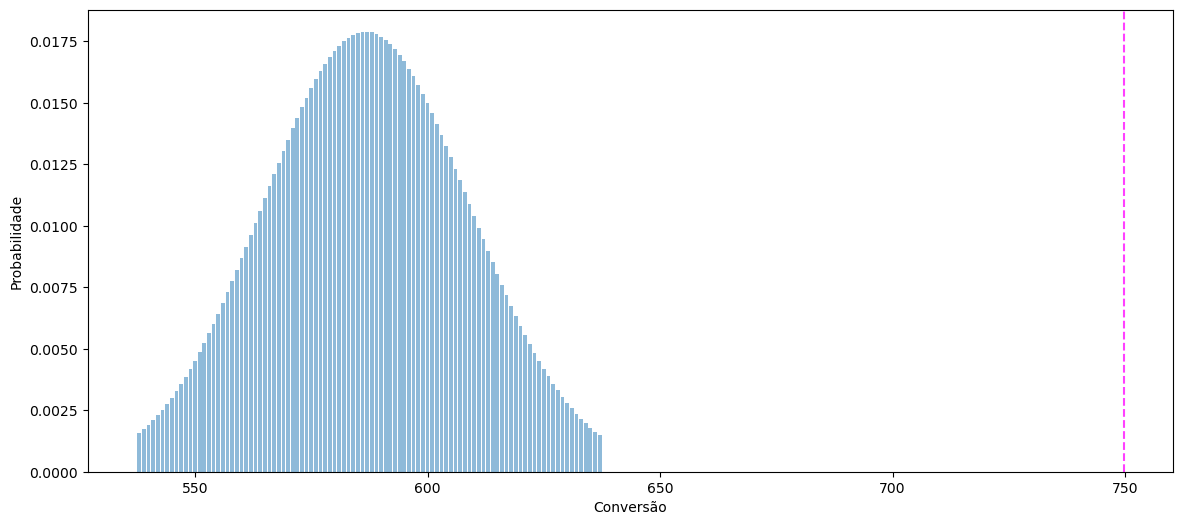

In [48]:
# Plot da distribuição do grupo A (controle)

# Área de plotagem
fig, ax = plt.subplots(figsize = (14,6))

# Teste de A
x = np.linspace(conversao_A - 49, conversao_A + 50, 100)
y = scs.binom(total_A, taxa_A).pmf(x)

# Cria a barra vertical
ax.bar(x, y, alpha = 0.5)
ax.axvline(x = taxa_B * total_A, c = 'magenta', alpha = 0.75, linestyle = '--')

# Labels
plt.xlabel('Conversão')
plt.ylabel('Probabilidade')

Text(0, 0.5, 'Probabilidade')

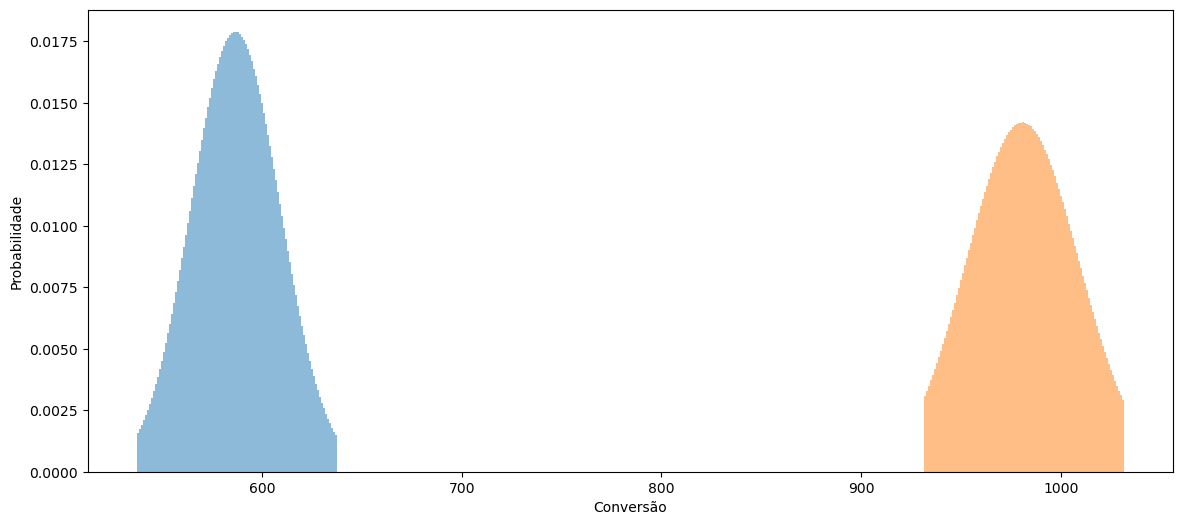

In [49]:
# Plot da distribuição dos 2 grupos

# Área de plotagem 
fig, ax = plt.subplots(figsize = (14,6))

# Gráfico de A
xA = np.linspace(conversao_A - 49, conversao_A + 50, 100)
yA = scs.binom(total_A, taxa_A).pmf(xA)
ax.bar(xA, yA, alpha = 0.5)

# Gráfico de B
xB = np.linspace(conversao_B - 49, conversao_B + 50, 100)
yB = scs.binom(total_B, taxa_B).pmf(xB)
ax.bar(xB, yB, alpha = 0.5)

# Labels
plt.xlabel('Conversão')
plt.ylabel('Probabilidade')

Podemos ver que o grupo de teste converteu mais usuários do que o grupo de controle. Também podemos ver que o pico dos resultados do grupo de teste é inferior ao do grupo de controle. 

Mas como interpretamos a diferença no pico da probabilidade? 

Devemos nos concentrar, em vez disso, na taxa de conversão para que tenhamos uma comparação de termos equivalentes. Para calcular isso, precisamos padronizar os dados e comparar a probabilidade de sucesso, p, para cada grupo.

In [50]:
# Ajusta o nome das variáveis

# Probabilidades (taxas de conversão)
p_A = taxa_A
p_B = taxa_B

# Número de conversões
N_A = 3821
N_B = 5000

In [51]:
# Erro padrão (standard error) para a média de ambos os grupos
SE_A = np.sqrt(p_A * (1 - p_A)) / np.sqrt(total_A)
SE_B = np.sqrt(p_B * (1 - p_B)) / np.sqrt(total_B)

In [52]:
# Print
print(SE_A)
print(SE_B)

0.005833423432971666
0.0056161474339621814


Text(0, 0.5, 'PDF - Probability Density Function')

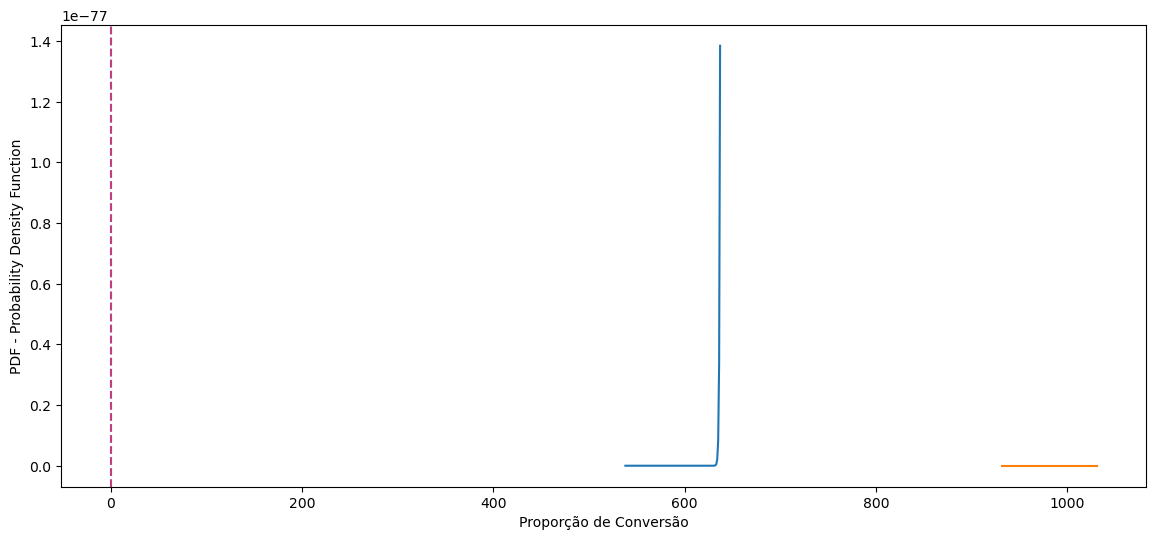

In [53]:
# Plot das distribuições das hipóteses nula e alternativa

# Área de plotagem
fig, ax = plt.subplots(figsize = (14,6))

# Dados para a variável aleatória
x = np.linspace(0, p_B - p_A, 100)

# Distribuição de A
yA = scs.norm(p_A, SE_A).pdf(x)
ax.plot(xA, yA)
ax.axvline(x = p_A, c = 'blue', alpha = 0.5, linestyle = '--')

# Distribuição de B
yB = scs.norm(p_B, SE_B).pdf(x)
ax.plot(xB, yB)
ax.axvline(x = p_B, c = 'red', alpha = 0.5, linestyle = '--')

# Labels
plt.xlabel('Proporção de Conversão')
plt.ylabel('PDF - Probability Density Function')

As linhas contínuas representam a taxa de conversão média para cada grupo. A distância entre a linha azul e a linha vermelha é igual à diferença média entre o grupo de controle e teste. 

### Verificando a Hipótese Nula e a Hipótese Alternativa

In [54]:
# Calculando a probabilidade agrupada
prob_agrupada = (p_A * N_A + p_B * N_B) / (N_A + N_B)

In [55]:
# Calculando z
z = (p_B - p_A) / (prob_agrupada * (1 - prob_agrupada) * (1 / N_A + 1 / N_B))**0.5
z

5.1827257006909795

In [56]:
# Verificamos se z é maior que 1.64 (nível de significância de 0.05)
z > 1.64

True

### Plot da Distribuição de Probabilidade


In [57]:
# Função que retorna a probabilidade agrupada para 2 amostras
def prob_agrupada_func(N_A, N_B, X_A, X_B):
    return (X_A + X_B) / (N_A + N_B)

In [58]:
# Função que retorna o erro padrão agrupado para 2 amostras
def erro_padrao_agrupado_func(N_A, N_B, X_A, X_B):
    p_hat = prob_agrupada_func(N_A, N_B, X_A, X_B)
    SE = np.sqrt(p_hat * (1 - p_hat) * (1 / N_A + 1 / N_B))
    return SE

In [59]:
# Retorna o valor z para um determinado nível de significância
def z_val(sig_level = 0.05, two_tailed = True):
    
    # Gera distribuição para o valor z
    z_dist = scs.norm()
    
    # Verifica se devemos checar as duas caudas
    if two_tailed:
        sig_level = sig_level/2
        area = 1 - sig_level
    else:
        area = 1 - sig_level

    # Valor de z
    z = z_dist.ppf(area)

    return z

In [60]:
# Calcula o intervalo de confiança
def confidence_interval(sample_mean = 0, sample_std = 1, sample_size = 1, sig_level = 0.05):
    
    # Calcula o valor de z
    z = z_val(sig_level)

    # Limites à esquerda e direita
    left = sample_mean - z * sample_std / np.sqrt(sample_size)
    right = sample_mean + z * sample_std / np.sqrt(sample_size)

    return (left, right)

In [61]:
# Função que calcula o intervalo de confiança de duas caudas 
def plot_CI(ax, 
            mu, 
            s, 
            sig_level = 0.05, 
            color = 'grey'):

    # Calcula o intervalo de confiança
    left, right = confidence_interval(sample_mean = mu, sample_std = s, sig_level = sig_level)
    
    # Inclui o intervalo no gráfico
    ax.axvline(left, c = color, linestyle = '--', alpha = 0.5)
    ax.axvline(right, c = color, linestyle = '--', alpha = 0.5)

In [62]:
# Função para o plot de uma distribuição normal
def plot_norm_dist(ax, 
                   mu, 
                   std, 
                   with_CI = False, 
                   sig_level = 0.05, 
                   label = None):

    # Gera valores para a variável aleatória x
    x = np.linspace(mu - 12 * std, mu + 12 * std, 1000)
    
    # Cria a distribuição normal
    y = scs.norm(mu, std).pdf(x)
    
    # Plot
    ax.plot(x, y, label = label)

    # Se tivermos intervalo de confiança, incluímos no plot
    if with_CI:
        plot_CI(ax, mu, std, sig_level = sig_level)

In [63]:
# Função para o plot da distribuição da H0
def plot_H0(ax, stderr):
    plot_norm_dist(ax, 0, stderr, label = "H0 - Hipótese Nula")
    plot_CI(ax, mu = 0, s = stderr, sig_level = 0.05)

In [64]:
# Função para o plot da distribuição da H1
def plot_H1(ax, stderr, d_hat):
    plot_norm_dist(ax, d_hat, stderr, label = "H1 - Hipótese Alternativa")

In [65]:
# Função que preenche entre o limite de significância superior e a distribuição para hipótese alternativa
def show_area(ax, d_hat, stderr, sig_level):

    # Intervalo de confiança
    left, right = confidence_interval(sample_mean = 0, sample_std = stderr, sig_level = sig_level)
    
    # Valores para x
    x = np.linspace(-12 * stderr, 12 * stderr, 1000)
    
    # H0
    null = ab_dist(stderr, 'controle')
    
    # H1
    alternative = ab_dist(stderr, d_hat, 'teste')

    # Se o tipo da área for igual a power
    # Preenchemos entre o limite de significância superior e a distribuição para hipótese alternativa
    ax.fill_between(x, 0, alternative.pdf(x), color = 'green', alpha = 0.25, where = (x > right))
    ax.text(-3 * stderr, null.pdf(0), 'power = {0:.3f}'.format(1 - alternative.cdf(right)), 
                fontsize = 12, ha = 'right', color = 'k')

In [66]:
# Função que retorna um objeto de distribuição dependendo do tipo de grupo
def ab_dist(stderr, d_hat = 0, group_type = 'controle'):

    # Verifica o tipo de grupo
    if group_type == 'controle':
        sample_mean = 0
    elif group_type == 'teste':
        sample_mean = d_hat

    # Cria uma distribuição normal que depende da média e do desvio padrão
    dist = scs.norm(sample_mean, stderr)
    return dist

In [67]:
# Função que retorna o valor p
def p_val(N_A, N_B, p_A, p_B):
    return scs.binom(N_A, p_A).pmf(p_B * N_B)

In [68]:
# Função para o plot da análise do Teste A/B
def abplot_func(N_A, 
                N_B, 
                bcr, 
                d_hat, 
                sig_level = 0.05, 
                show_p_value = False,
                show_legend = True):
   
    # Define a área de plotagem
    fig, ax = plt.subplots(figsize = (14, 8))

    # Define parâmetros para encontrar o erro padrão agrupado
    X_A = bcr * N_A
    X_B = (bcr + d_hat) * N_B
    stderr = erro_padrao_agrupado_func(N_A, N_B, X_A, X_B)

    # Plot da distribuição da hipótese nula e alternativa
    plot_H0(ax, stderr)
    plot_H1(ax, stderr, d_hat)

    # Definir a extensão da área do plot
    ax.set_xlim(-8 * stderr, 8 * stderr)

    # Ajustamos o gráfico e preenchemos a área interior
    show_area(ax, d_hat, stderr, sig_level)

    # Mostramos valores-p com base nas distribuições para os dois grupos
    if show_p_value:
        null = ab_dist(stderr, 'controle')
        p_value = p_val(N_A, N_B, bcr, bcr + d_hat)
        ax.text(3 * stderr, null.pdf(0), 'Valor-p = {0:.4f}'.format(p_value), fontsize = 14, ha = 'left')

    # Mostra a legenda
    if show_legend:
        plt.legend()

    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()

Agora que entendemos a derivação do erro padrão combinado, podemos apenas plotar diretamente as hipóteses nula e alternativa para experimentos futuros. Tudo que precisamos é executar a célula abaixo.

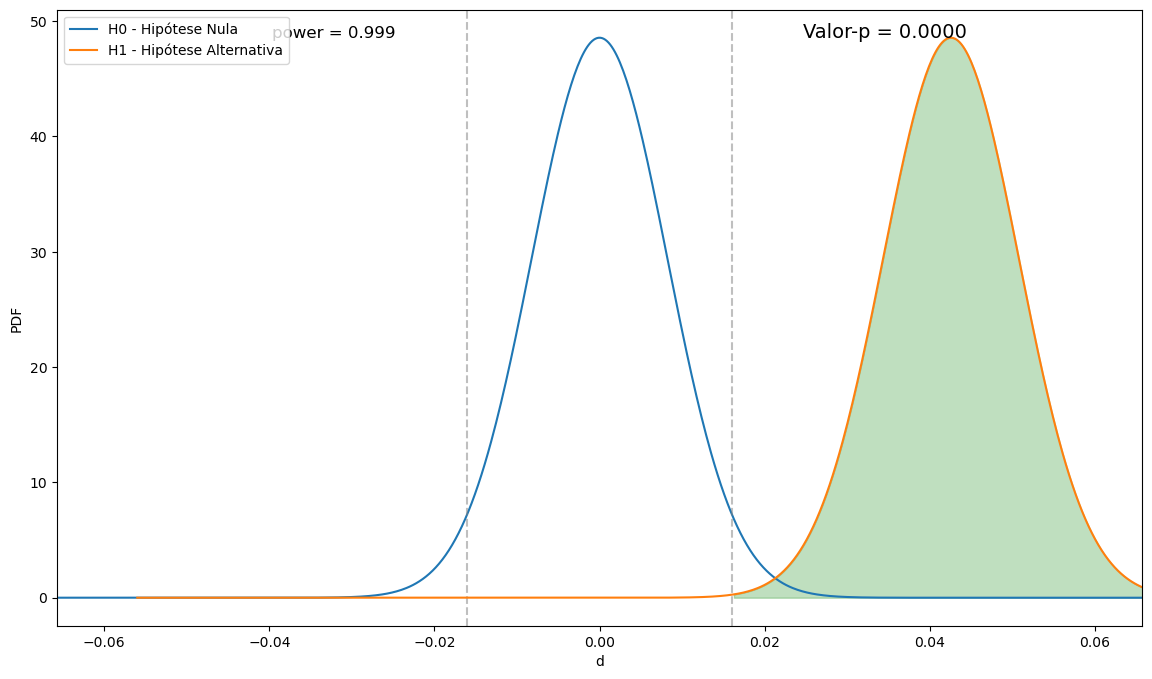

In [69]:
# Definimos os parâmetros e executamos a função
n = N_A + N_B
conversao_base = p_A  
d_hat = p_B - p_A
abplot_func(N_A, N_B, conversao_base, d_hat, show_p_value = True)

Visualmente, o gráfico para as hipóteses nula e alternativa é muito semelhante aos outros gráficos acima. Felizmente, as duas curvas têm formato idêntico, portanto, podemos apenas comparar a distância entre as médias das duas distribuições. Podemos ver que a curva de hipótese alternativa sugere que o grupo de teste tem uma taxa de conversão maior do que o grupo de controle. Este gráfico também pode ser usado para determinar diretamente o poder estatístico.

## Tarefa 4 - Calculando o Poder Estatístico

Poder Estatístico e Nível de Significância

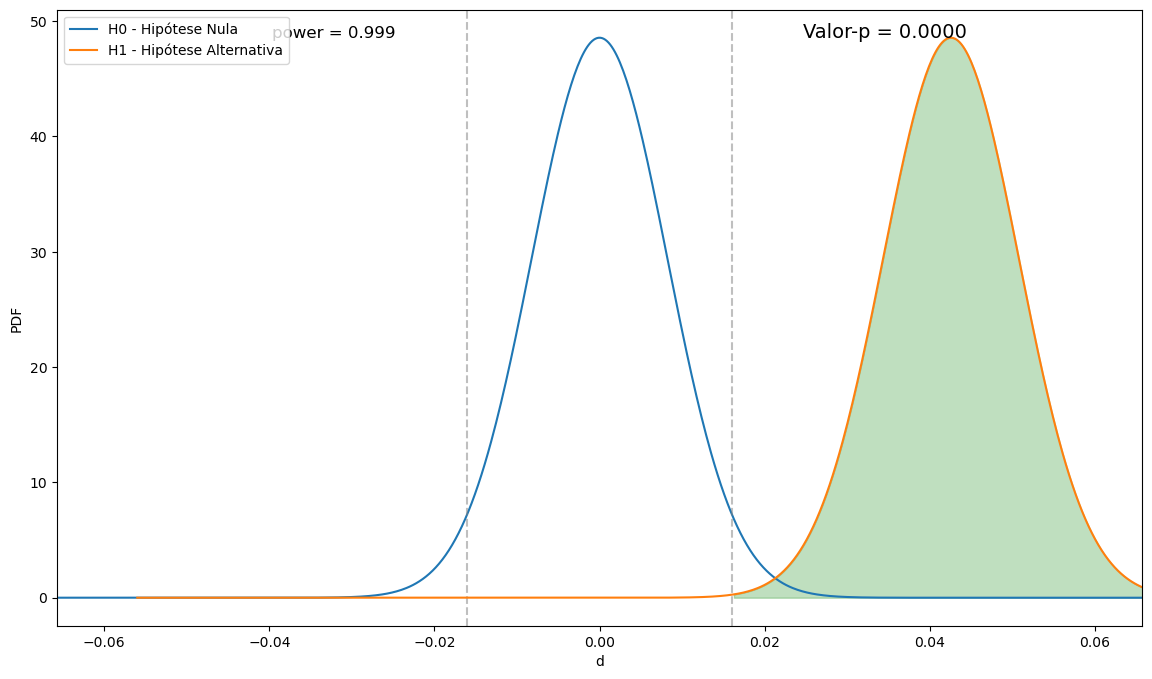

In [70]:
# Executa a função
abplot_func(N_A, N_B, conversao_base, d_hat, show_p_value = True)

## Tarefa 5 - Influência do Tamanho da Amostra no Teste A/B

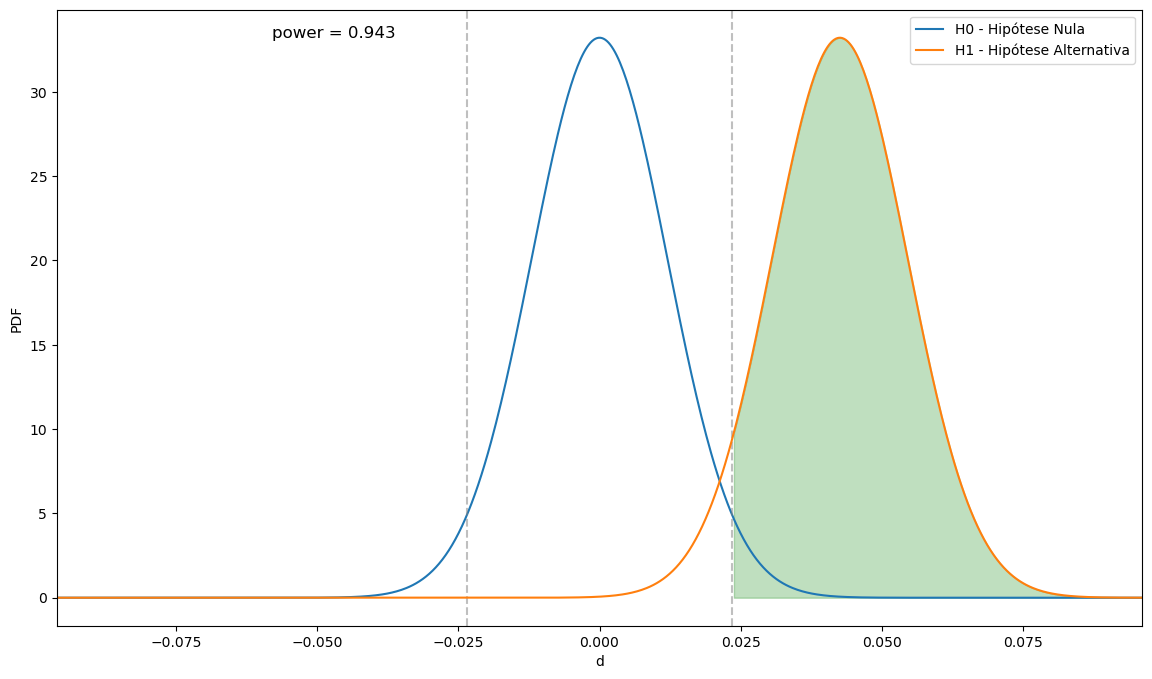

In [71]:
# Executa a função
abplot_func(2000, 2000, conversao_base, d_hat)

Temos a taxa de conversão de linha de base e o efeito mínimo detectável, que é a diferença mínima entre o controle e o grupo de teste que a equipe de negócio determinará para valer a pena o investimento de fazer a mudança de design em primeiro lugar.

In [72]:
# Função para incluir o valor z no plot
def zplot(area = 0.95, two_tailed = True, align_right = False):

    # Cria a área de plotagem
    fig = plt.figure(figsize = (12, 6))
    ax = fig.subplots()
    
    # Cria a distribuição normal
    norm = scs.norm()
    
    # Cria os pontos de dados para o plot
    x = np.linspace(-5, 5, 1000)
    y = norm.pdf(x)

    ax.plot(x, y)

    # Código para preencher áreas para testes bidirecionais
    if two_tailed:
        left = norm.ppf(0.5 - area / 2)
        right = norm.ppf(0.5 + area / 2)
        ax.vlines(right, 0, norm.pdf(right), color = 'grey', linestyle = '--')
        ax.vlines(left, 0, norm.pdf(left), color = 'grey', linestyle = '--')

        ax.fill_between(x, 0, y, color = 'grey', alpha = 0.25, where = (x > left) & (x < right))
        
        plt.xlabel('z')
        plt.ylabel('PDF')
        plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left), 
                 fontsize = 12, 
                 rotation = 90, 
                 va = "bottom", 
                 ha = "right")
        plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right), 
                 fontsize = 12, 
                 rotation = 90, 
                 va = "bottom", 
                 ha = "left")
    
    # Para testes de uma cauda
    else:
        # Alinhamento à direita
        if align_right:
            left = norm.ppf(1-area)
            ax.vlines(left, 0, norm.pdf(left), color = 'grey', linestyle = '--')
            ax.fill_between(x, 0, y, color = 'grey', alpha = 0.25, where = x > left)
            plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left), 
                     fontsize = 12, 
                     rotation = 90, 
                     va = "bottom", 
                     ha = "right")
        
        # Alinhamento à esquerda
        else:
            right = norm.ppf(area)
            ax.vlines(right, 0, norm.pdf(right), color = 'grey', linestyle = '--')
            ax.fill_between(x, 0, y, color = 'grey', alpha = 0.25, where = x < right)
            plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right), 
                     fontsize = 12, 
                     rotation = 90, 
                     va = "bottom", 
                     ha = "left")

    # Incluímos texto no plot
    plt.text(0, 0.1, "Área Sombreada = {0:.3f}".format(area), fontsize = 12, ha = 'center')
    
    # Labels
    plt.xlabel('z')
    plt.ylabel('PDF')

    plt.show()

In [73]:
# Print do valor z
print(z)
print(z_val(sig_level = 0.05, two_tailed = False))
print(z > z_val(sig_level = 0.05, two_tailed = False))

5.1827257006909795
1.6448536269514722
True


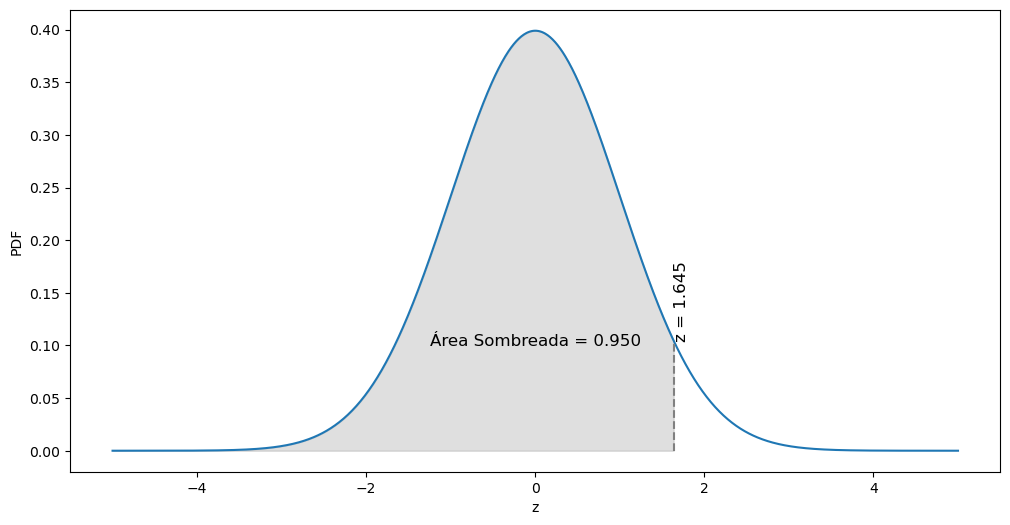

In [74]:
# Plot de z
zplot(area = 0.95, two_tailed = False, align_right = False)

Aqui está o código Python que executa o mesmo cálculo para o tamanho mínimo da amostra:

In [75]:
# Calculamos os valores de z alfa e beta
sig_level = 0.05
beta = 0.2
k = N_A/N_B
standard_norm = scs.norm(0, 1)
Z_beta = standard_norm.ppf(1-beta)
Z_alpha = standard_norm.ppf(1-sig_level)
print(Z_beta)
print(Z_alpha)

0.8416212335729143
1.6448536269514722


Vamos calcular o tamanho mínimo necessário para a amostra.

In [76]:
# Função para encontrar o tamanho mínimo da amostra
def calcula_tamanho_min_amostra(N_A, 
                                N_B, 
                                p_A, 
                                p_B, 
                                power = 0.8, 
                                sig_level = 0.05, 
                                two_sided = False):
   
    k = N_A/N_B
    
    # Distribuição normal para determinar os valores z
    standard_norm = scs.norm(0, 1)

    # Encontramos o valor de z para o poder estatístico
    Z_beta = standard_norm.ppf(power)
    
    # Encontramos z alfa
    if two_sided == True:
        Z_alpha = standard_norm.ppf(1-sig_level/2)
    else:
        Z_alpha = standard_norm.ppf(1-sig_level)

    # Probabilidade agrupada
    pooled_prob = (p_A + p_B) / 2

    # Tamanho mínimo da amostra
    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2 / efeito_minimo**2)    

    return min_N

In [77]:
# Calculamos o tamanho mínimo da amostra com two_sided = True
calcula_tamanho_min_amostra(N_A, N_B, p_A, p_B, power = 0.8, sig_level = 0.05, two_sided = True)

1249.8068972849476

In [78]:
# Calculamos o tamanho mínimo da amostra com two_sided = False
calcula_tamanho_min_amostra(N_A, N_B, p_A, p_B, power = 0.8, sig_level = 0.05, two_sided = False)

984.4720435225323

Agora vamos calcular o tamanho mínimo da amostra considerando nosso baseline.

In [79]:
conversao_base + efeito_minimo

0.1962

In [80]:
# Calcula a probabilidade agrupada
probabilidade_agrupada = (conversao_base + conversao_base + efeito_minimo) / 2
probabilidade_agrupada

0.1749123527872285

In [81]:
# Soma de z alfa e beta
Z_beta + Z_alpha

2.4864748605243863

In [82]:
# Tamanho mínimo da amostra para o baseline
min_N = (2 * probabilidade_agrupada * (1 - probabilidade_agrupada) * (Z_beta + Z_alpha)**2 / efeito_minimo**2)
min_N

984.4720435225323

Poder estatístico para o baseline.

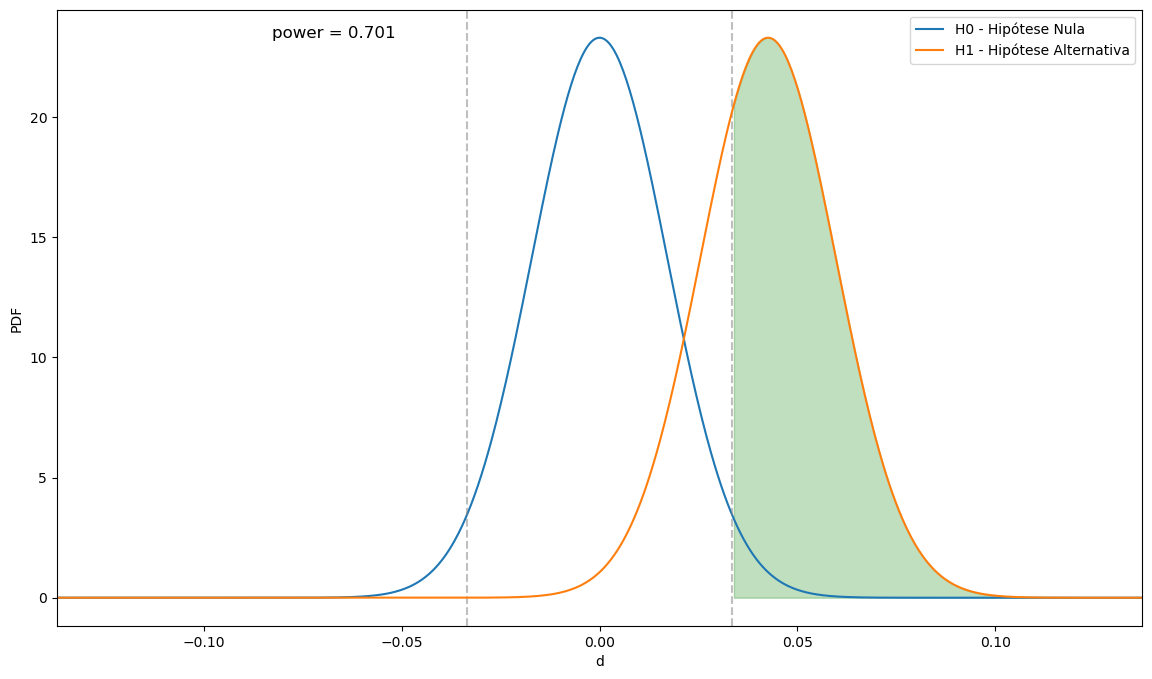

In [83]:
# Executa a função para 984 amostras
abplot_func(N_A = 984, 
            N_B = 984, 
            bcr = p_A, 
            d_hat = p_B - p_A, 
            sig_level = 0.05, 
            show_p_value = False, 
            show_legend = True)

Poder estatístico para o tamanho de amostra calculado.

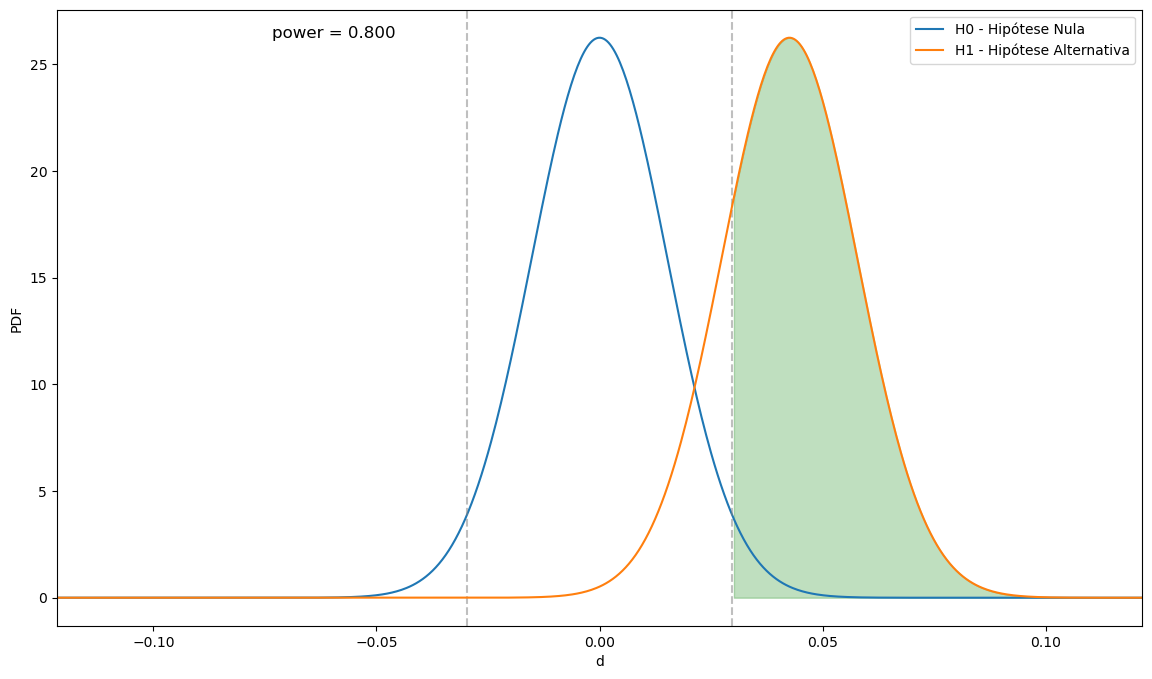

In [84]:
# Executa a função para 1249 amostras
abplot_func(N_A = 1249, 
            N_B = 1249, 
            bcr = p_A, 
            d_hat = p_B - p_A, 
            sig_level = 0.05, 
            show_p_value = False, 
            show_legend = True)

## Conclusão e Considerações Finais

O poder calculado para este tamanho de amostra foi de aproximadamente 0,80. Portanto, para afirmar que a mudança na página removendo as avaliações de usuários realmente aumentou a taxa de conversão precisamos de pelos menos 1249 amostras.